# Inferring parameters for a population of ToR-ORd models

In this notebook, we use PINTS to create noisy data for 50 ToR-ORd [$^{[1]}$](#Sources) systems (varying some conductances) and then perform inference on the model to try and retrieve the parameters. This should be compared with results from other notebooks, such as the `torord.ipynb` notebook. For further analysis and plots, see `torord_population_analysis.ipynb`.

## Creating the ForwardModel

### Variable descriptions

We need to set up the ODE system first. This is a large system and so we will not go through all the equations and varibles,
but we will give a description of all the currents and fluxes in the model and the important parameters (to be inferred).

|variable|description|ions|
|---|-------|---|
|$V$|membrane potential|all|
|$I_{Na}$|fast sodium current|$Na^{+}$|
|$I_{NaL}$|late sodium current|$Na^{+}$|
|$I_{to}$|transient outward potassium current|$K^{+}$|
|$I_{CaL}$|L-type calcium current|$Ca^{2+}$|
|$I_{K_r}$|rapid delayed rectifier potassium current|$K^{+}$|
|$I_{K_s}$|slow delayed rectifier potassium current|$K^{+}$|
|$I_{K_1}$|inward rectifier current|$K^{+}$|
|$I_{NaCa}$|sodium/calcium exchanger (NCX)|$Na^{+}$, $Ca^{2+}$|
|$I_{NaK}$|sodium/potassium pump|$Na^{+}$, $K^{+}$|
|$I_{Kb}$|background potassium current|$K^{+}$|
|$I_{Nab}$|background sodium current|$Na^{+}$|
|$I_{Cab}$|background calcium current|$Ca^{2+}$|
|$I_{pCa}$|calcium pump|$Ca^{2+}$|
|$I_{ClCa}$|calcium-sensitive chloride current|$Cl^{-}$|
|$I_{Clb}$|background chloride current|$Cl^{-}$|
|$J_{rel}$|calcium flux through ryanodine receptor|$Ca^{2+}$|
|$J_{up}$|calcium uptake into network sarcoplasmic reticulum via SERCA|$Ca^{2+}$|
|$J_{leak}$|calcium leak out of network sarcoplasmic reticulum|$Ca^{2+}$|
|$J_{tr}$|calcium NSR to JSR calcium translocation|$Ca^{2+}$|
|$J_{diff,Na}$|sodium diffusion flux between myoplasm and subspace|$Na^{+}$|
|$J_{diff,K}$|potassium diffusion flux between myoplasm and subspace|$K^{+}$|
|$J_{diff}$|calcium diffusion flux between myoplasm and subspace|$Ca^{2+}$|
|CMDN|calmodulin buffer|$Ca^{2+}$|
|TRPN|troponin buffer|$Ca^{2+}$|
|CSQN|calsequestrin buffer|$Ca^{2+}$|
|BSR|anionic sarcoplasmic reticulum binding sites for calcium|$Ca^{2+}$|
|BSL|anionic sarcolemmal binding sites for calcium|$Ca^{2+}$|
|CaMKII|calmodulin-dependent protein kinase II|$Ca^{2+}$|

We will not go into any major detail with the equations, but the main membrane potential ODE is a sum of all the above
currents added to a stimulating current, $I_{stim}$ which provides the action potential shape. We also note here that the
ToR-ORd model has $43$ time dependent variables forming a system of $43$ ordinary differential equations.

|variable group|list of variables|ions|
|---|---|---|
|Membrane potential|$V$|all|
|Ion compartment concentrations|$[Na]_{i}, [Na]_{ss}, [K]_{i}, [K]_{ss}, [Ca]_{i}, [Ca]_{ss}, [Ca]_{nsr}, [Ca]_{jsr}$|$Na^{+}, K^{+}, Ca^{2+}$|
|$I_{Na}$ gating variables|$m, h_{p}, h, j, j_{p}$|$Na^{+}$|
|$I_{NaL}$ gating variables|$m_L, h_L, h_{Lp}$|$Na^{+}$|
|$I_{to}$ gating variables|$a, i_{F}, i_{S}, a_{p}, i_{Fp}, i_{Sp}$|$K^{+}$|
|$I_{CaL}$ gating variables|$d, f_{f}, f_{s}, f_{caf}, f_{cas}, j_{ca}, n_{ca}, n_{cai}, f_{fp}, f_{cafp}$|$K^{+}$|
|$I_{K_r}$ gating variables|$C_{0}, C_{1}, C_{2}, O, I$|$K^{+}$|
|$I_{K_s}$ gating variables|$x_{s1}, x_{s2}$|$K^{+}$|
|$J_{rel}$|$J_{relp}, J_{relnp}$|$Ca^{2+}$|
|CaMKII buffer|$CaMK_{t}$|$Ca^{2+}$|

### Initial conditions

We will use the following initial conditions, representing an endocardial cell.

In [1]:
initial_conditions = [-88.8691566357934,12.0996647655188,12.1000028563765,142.412524737626,142.412481425842,7.45541572746214e-05,
                      6.50418928341426e-05,1.53037019085812,1.52803094224238,0.000787657400526199,0.674096901201792,0.830658198588696,
                      0.830466744399495,0.830093612199637,0.000159670117055769,0.528261721740178,0.288775833197764,0.000944249645410894,
                      0.999616956857814,0.593680589620082,0.000481107253796778,0.999616964658062,0.654092074678260,8.86091322819384e-29,
                      0.999999992783113,0.938965241412012,0.999999992783179,0.999900458262832,0.999977476316330,0.000492094765239740,
                      0.000833711885764158,0.999999992566681,0.999999992766279,0.247156543918935,0.000175017075236424,3.90843796133124e-24,
                      0.0110752904836162,0.998073652444028,0.000844745297078649,0.000698171876592920,0.000370404872169913,1.30239063420973e-05,
                      -1.88428892080206e-22]

In [2]:
import pints
import numpy as np
import scipy.integrate as si
import nbkode
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit

import torord_rhs_new

### PINTS implementation of the model

In addition to implementing the system, we give the option in the class to specify fixed parameters, if we wish to 
reduce the dimensions of the parameter space. Additionally, as we realistically would only be able to measure the membrane potential,
$V$, and the calcium concentration, $c$, we will use these as the only outputs of the system.

The system of equations from the model have been adapted from the original MATLAB code from the ToR-ORd github repository [$^{[5]}$](#Sources).

In [3]:
import time
import chi

In [4]:
class ToRORdModel(pints.ForwardModel, chi.MechanisticModel):

    def __init__(self, initial_conditions, stimulating_current, fixed_params=None, outputs=["V", "c"],
                 rtol=10**(-3), atol=10**(-6)):
        """Initialises the forward model with certain fixed parameters passed to the method
        as key-value pairs.
        """
        super(ToRORdModel, self).__init__()
        assert len(initial_conditions) == 43
        self._initial_conditions = initial_conditions
        # The current conditions represent the state of the model after one beat
        self._current_conditions = initial_conditions
        self._reset_model = True

        assert len(stimulating_current) == 2
        self._stim_duration, self._stim_amplitude = tuple(stimulating_current)
        self._param_names = ["G_Na", "P_Cab", "G_Kr", "G_ClCa", "G_Clb", "G_to"]
        self._variable_names = ["V", "Na_i", "Na_ss", "K_i", "K_ss", "Ca_i", "Ca_ss", "Ca_nsr", "Ca_jsr",
                                "m", "hp", "h", "j", "jp",
                                "mL", "hL", "hLp",
                                "a", "iF", "iS", "ap", "iFp", "iSp",
                                "d", "ff", "fs", "fcaf", "fcas", "jca", "nca", "nca_i", "ffp", "fcafp",
                                "xs1", "xs2",
                                "Jrel_np", "CaMKt",
                                "ikr_c0", "ikr_c1", "ikr_c2", "ikr_o", "ikr_i",
                                "Jrel_p"]
        self._fixed_params = {}
        if fixed_params is not None:
            for k in fixed_params.keys():
                if k in self._param_names:
                    self._fixed_params[k] = fixed_params[k]

        assert 1 <= len(outputs) <= 43
        assert set(outputs).issubset(set(self._variable_names))
        self._outputs = outputs
        self._rtol = rtol
        self._atol = atol
        # If we wish to specific current or flux multipliers, we do so in the dict below (e.g. for blocking channels)
        self.multipliers = {"I_CaL": 1, "I_Na": 1, "I_to": 1, "I_NaL": 1, "I_Kr": 1, "I_Ks": 1, "I_K1": 1, "I_Kb": 1,
                             "I_NaCa": 1, "I_NaK": 1, "I_Nab": 1, "I_Cab": 1, "I_pCa": 1, "I_CaCl": 1, "I_Clb": 1,
                             "J_rel": 1, "J_up": 1}
        # If we wish to change the extracellular concentrations or subspace fractions, we do so here
        self.concs_and_fractions = {"Na_o": 140.0, "Ca_o": 1.8, "K_o": 5.0, "ICaL_fractionSS": 0.8, "INaCa_fractionSS": 0.35}

    def get_param_names(self):
        """Returns the parameter names.
        """
        return self._param_names

    def get_unfixed_param_names(self):
        """Returns the unfixed parameters
        """
        output_list = self._param_names.copy()
        for fixed_param in self._fixed_params.keys():
            output_list.remove(fixed_param)
        return output_list

    def n_outputs(self):
        """Returns number of model outputs, default to just V and c
        """
        return len(self._outputs)

    def n_parameters(self):
        """Returns number of parameters to be inferred, i.e. all non-fixed parameters.
        """
        return len(self._param_names) - len(self._fixed_params)

    def n_fixed_parameters(self):
        """Returns number of parameters we fix.
        """
        return len(self._fixed_params)

    def enable_sensitivities(self):
        return

    def has_sensitivities(self):
        return False

    def outputs(self):
        return self._outputs

    def parameters(self):
        return self.get_param_names()

    def simulate(self, parameters, times):
        """This inherits from pints.ForwardModel, performs one forward simulation of the model.
        The list `parameters` contains only the parameters we are inferring.
        """
        G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to = self._get_all_params(parameters)
        t_span = [times[0], times[len(times) - 1]]
        
        # For the line below, our starting state will either be the true initial conditions,
        # or the conditions of the model at the end of the last heartbeat
        y0 = self._initial_conditions if self._reset_model else self._current_conditions        
        # start = time.process_time()
        sol = si.odeint(func=self._rhs, y0=y0, t=times, 
                        args=(G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to,
                              self._stim_duration, self._stim_amplitude, 
                              np.array(list(self.multipliers.values())), 
                              np.array(list(self.concs_and_fractions.values()))),
                        rtol=self._rtol, atol=self._atol)
        # sol = si.solve_ivp(fun=self._rhs, y0=y0, t_span=t_span, t_eval=times, 
        #                    args=(G_Na, P_Cab, G_Kr, G_ClCa, G_Clb,
        #                          self._stim_duration, self._stim_amplitude, 
        #                          self.multipliers, self.concs_and_fractions),
        #                    rtol=self._rtol, atol=self._atol, method="BDF")
        # print(time.process_time() - start)
        # Update the current conditions
        self._current_conditions = sol[-1, :]

        # Now we find which outputs we wish to use
        output_indices = [self._variable_names.index(variable) for variable in self._outputs]
        return np.array([sol[:, index] for index in output_indices]).transpose()

    def simulate_beats(self, parameters, times, num_beats, num_saved_beats=1):
        """This method imitates how ToR-ORd is initially run, by starting with some arbitrary initial conditions
        and then simulating a number of beats to get the model into an oscillatory state. This is the only time
        in which reset_model flag is set to False, as we wish for a continuous set of beats.
        """
        self._reset_model = False
        output_list = []
        for beat in range(num_beats):
            print(beat, end='_/\_')
            data = self.simulate(parameters, times)
            if num_beats - beat <= num_saved_beats:
                output_list.append(data)
        self._reset_model = True
        return np.vstack(output_list)

    def _get_all_params(self, parameters):
        """We need a list of 6 parameters, so we check to see which parameters are fixed, and which are not.
        We increment j each time a non-fixed parameter is reached.
        """
        all_parameters = []
        j = 0
        for param in self._param_names:
            if param in self._fixed_params.keys():
                all_parameters.append(self._fixed_params[param])
            else:
                all_parameters.append(parameters[j])
                j += 1
        return tuple(all_parameters)

    @staticmethod
    @jit
    def _rhs(y, t, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to, stim_duration, stim_amplitude, multipliers, concs_and_fractions):
        """The right hand side function of the ToR-ORd system. This is in a separate file as it is 
        a very long system of equations.
        """
        # rhs = ToRORdRHS(t, y, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions)
        rhs = torord_rhs_new.evaluate(t, y, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, G_to, stim_duration, stim_amplitude, 
                                      multipliers, concs_and_fractions)
        return np.array(rhs)

    # @staticmethod
    # def _rhs(t, y, params):
    #     """The right hand side function of the ToR-ORd system. This is in a separate file as it is 
    #     a very long system of equations.
    #     """
    #     G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions = params
    #     rhs = ToRORdRHS(t, y, G_Na, P_Cab, G_Kr, G_ClCa, G_Clb, stim_duration, stim_amplitude, multipliers, concs_and_fractions)
    #     return np.array(rhs.evaluate())

<>:123: SyntaxWarning: invalid escape sequence '\_'
<>:123: SyntaxWarning: invalid escape sequence '\_'
C:\Users\matth\AppData\Local\Temp\ipykernel_23976\2054155654.py:123: SyntaxWarning: invalid escape sequence '\_'
  print(beat, end='_/\_')


## Generating data for the models

### Setting up the systems

All of the currents have corresponding conductances, and the fluxes have corresponding multipliers. The conductances we will
be most interested in for the purpose of inference are listed in the table below.

|conductance|ToR-ORd value [$^{[1]}$](#Sources)|ion|reasoning for inference|
|---|---|---|-------|
|$G_{Na}$|$11.7802$|$Na^{+}$|Multiple changes were made: the Grandi [$^{[2]}$](#Sources) model was used with ORd [$^{[3]}$](#Sources) CaMKII phosphorylation.|
|$P_{Cab}$|$8.3757 \times 10^{-5}$|$Ca^{2+}$|The L-type calcium current had the largest revision of them all compared to the ORd model.|
|$G_{K_r}$|$0.0321$|$K^{+}$|This was changed to have a Markovian [$^{[4]}$](#Sources) formulation, as originally parameter inference could not fit the action potential.|
|$G_{ClCa}$|$0.2843$|$Cl^{-}$|This current was added for the purpose of fitting to the shape of the action potential.|
|$G_{Clb}$|$0.00198$|$Cl^{-}$|This current was added for the purpose of fitting to the shape of the action potential.|
|$G_{to}$|$0.16$|$K^{+}$|---|

In [5]:
# Here we choose which parameters to fix in the simulation
fixed_params = {"G_Na": 11.7802, "G_Clb": 0.00198, "G_to": 0.16}
# fixed_params = {"G_Clb": 0.00198}
# fixed_params = None
# Stimulation parameters [stim_duration, stim_amplitude]
stim_params = [1, -53]
models = [ToRORdModel(initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
          for i in range(50)]
param_names = models[0].get_unfixed_param_names()

Here, we will generate 50 parameter sets for some of the conductances, using a Gaussian distribution, to create our population of models. Each standard deviation is chosen to be 15% of the mean.

|conductance|mean|standard deviation|
|---|---|---|
|$G_{Na}$|$11.7802$|$1.76703$|
|$P_{Cab}$|$8.3757 \times 10^{-5}$|$1.256355 \times 10^{-5}$|
|$G_{K_r}$|$0.0321$|$0.004815$|
|$G_{ClCa}$|$0.2843$|$0.042645$|
|$G_{Clb}$|$0.00198$|$0.000297$|
|$G_{to}$|$0.16$|$0.024$|

In [6]:
np.random.seed(42)
means = np.array([8.3757e-5, 0.0321, 0.2843])
std_devs = means * 0.15
conductance_array = np.random.normal(means, std_devs, size=(50, 3))
conductance_df = pd.DataFrame(conductance_array, columns=param_names)
conductance_df.to_csv("conductances_new.csv")

array([[<Axes: title={'center': 'P_Cab'}>,
        <Axes: title={'center': 'G_Kr'}>,
        <Axes: title={'center': 'G_ClCa'}>]], dtype=object)

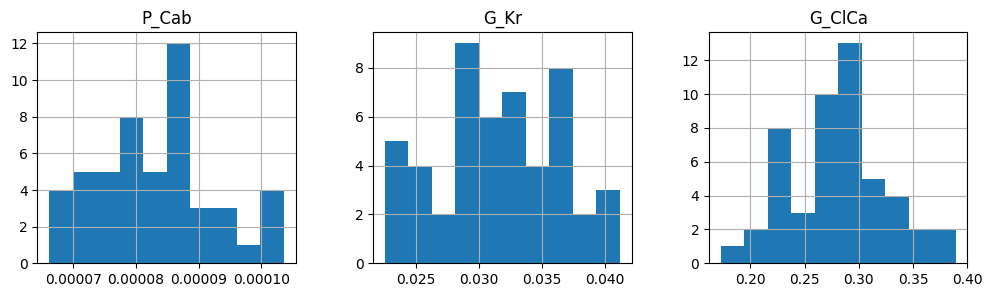

In [6]:
num_rows, num_columns = 1, 3
conductance_df = pd.read_csv("conductances.csv", index_col=0)
conductances = conductance_df.to_numpy()
conductance_df.hist(layout=(num_rows, num_columns), figsize=(12, 3))

In [7]:
output_param_dfs = []
for i in range(50):
    output_param_dfs.append(pd.DataFrame({"true": conductance_df.iloc[i].to_numpy()}))

### Pre-pacing the model

Now we will pre-pace all 50 models according to how this was done in the paper by Tomek et al.[$^{[1]}$](#Sources)

In [8]:
times = times = np.arange(0, 1000, 2)

In [9]:
def pre_pace(model, parameters, times, num_beats, num_saved_beats):
    data = model.simulate_beats(parameters, times, num_beats=num_beats, num_saved_beats=num_saved_beats)
    current_conditions = model._current_conditions
    model._initial_conditions = current_conditions
    return current_conditions

In [12]:
conditions_130_list = []
for i, model in enumerate(models):
    conditions_130_list.append(pre_pace(model, conductances[i, :], times, num_beats=130, num_saved_beats=1))

0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_20_/\_21_/\_22_/\_23_/\_24_/\_25_/\_26_/\_27_/\_28_/\_29_/\_30_/\_31_/\_32_/\_33_/\_34_/\_35_/\_36_/\_37_/\_38_/\_39_/\_40_/\_41_/\_42_/\_43_/\_44_/\_45_/\_46_/\_47_/\_48_/\_49_/\_50_/\_51_/\_52_/\_53_/\_54_/\_55_/\_56_/\_57_/\_58_/\_59_/\_60_/\_61_/\_62_/\_63_/\_64_/\_65_/\_66_/\_67_/\_68_/\_69_/\_70_/\_71_/\_72_/\_73_/\_74_/\_75_/\_76_/\_77_/\_78_/\_79_/\_80_/\_81_/\_82_/\_83_/\_84_/\_85_/\_86_/\_87_/\_88_/\_89_/\_90_/\_91_/\_92_/\_93_/\_94_/\_95_/\_96_/\_97_/\_98_/\_99_/\_100_/\_101_/\_102_/\_103_/\_104_/\_105_/\_106_/\_107_/\_108_/\_109_/\_110_/\_111_/\_112_/\_113_/\_114_/\_115_/\_116_/\_117_/\_118_/\_119_/\_120_/\_121_/\_122_/\_123_/\_124_/\_125_/\_126_/\_127_/\_128_/\_129_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_20_/\_21_/\_22_/\_23_/\_24_/\_25_/\_26_/\_27_/\_28_/\_29_/\_30_/\_31_/\_32_/\_33_/\_34_/\_

Next, we have to take into account various ion channel block conditions, following the above paper, so we do a further 20 beats of pre-pacing for four different conditions with different blocks.

In [10]:
model_defaults = []
model_BINa_list = []
model_BICaL_list = []
model_BIK1_list = []
for i in range(50):
    model_defaults.append(models[i])
    model_BINa = ToRORdModel(models[i]._initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
    model_BINa.multipliers["I_Na"] = 0.5
    model_BINa.multipliers["I_NaL"] = 0.5
    model_BINa_list.append(model_BINa)
    model_BICaL = ToRORdModel(models[i]._initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
    model_BICaL.multipliers["I_CaL"] = 0.5
    model_BICaL_list.append(model_BICaL)
    model_BIK1 = ToRORdModel(models[i]._initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "Ca_i"], rtol=10**(-8), atol=10**(-8))
    model_BIK1.multipliers["I_K1"] = 0.5
    model_BIK1_list.append(model_BIK1)

In [14]:
for i in range(50):
    pre_pace(model_defaults[i], conductances[i, :], times, num_beats=20, num_saved_beats=1)
    pre_pace(model_BINa_list[i], conductances[i, :], times, num_beats=20, num_saved_beats=1)
    pre_pace(model_BICaL_list[i], conductances[i, :], times, num_beats=20, num_saved_beats=1)
    pre_pace(model_BIK1_list[i], conductances[i, :], times, num_beats=20, num_saved_beats=1)

0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_2_/\_3_/\_4_/\_5_/\_6_/\_7_/\_8_/\_9_/\_10_/\_11_/\_12_/\_13_/\_14_/\_15_/\_16_/\_17_/\_18_/\_19_/\_0_/\_1_/\_

Save the pre-paced conditions.

In [15]:
for i in range(50):
    default_df = pd.DataFrame({"ICs": model_defaults[i]._initial_conditions})
    BINa_df = pd.DataFrame({"ICs": model_BINa_list[i]._initial_conditions})
    BICaL_df = pd.DataFrame({"ICs": model_BICaL_list[i]._initial_conditions})
    BIK1_df = pd.DataFrame({"ICs": model_BIK1_list[i]._initial_conditions})
    default_df.to_csv(f"simulation_outputs/default/ics_{i}.csv")
    BINa_df.to_csv(f"simulation_outputs/BINa/ics_{i}.csv")
    BICaL_df.to_csv(f"simulation_outputs/BICaL/ics_{i}.csv")
    BIK1_df.to_csv(f"simulation_outputs/BIK1/ics_{i}.csv")

### Adding noise to the systems

Next we create problems for each model. We now utilise PINTS noise generators to create some noisy data for the system. Specifically, `pints.noise.independent`
creates independent Gaussian noise iid $\mathcal{N}(0, \sigma)$.

In [51]:
def generate_data(model, parameters, times, sigma, file_loc=None, columns=["V", "Ca_i"]):
    data = model.simulate(parameters, times)
    noisy_data = data + pints.noise.independent(sigma, data.shape)
    noisy_df = pd.DataFrame(noisy_data, columns=columns)
    if file_loc is not None:
        noisy_df.to_csv(file_loc)
    return data

Save the noisy data below. This section should only be run once to generate the noisy data (provided it is valid).

In [56]:
data_default_list = []
data_BINa_list = []
data_BICaL_list = []
data_BIK1_list = []
for i in range(50):
    data_default_list.append(generate_data(model_defaults[i], conductances[i, :], times, sigma=np.array([1, 3e-6]), 
                                           file_loc=None))
    data_BINa_list.append(generate_data(model_BINa_list[i], conductances[i, :], times, sigma=np.array([1, 3e-6]), 
                                        file_loc=None))
    data_BICaL_list.append(generate_data(model_BICaL_list[i], conductances[i, :], times, sigma=np.array([1, 3e-6]),
                                         file_loc=None))
    data_BIK1_list.append(generate_data(model_BIK1_list[i], conductances[i, :], times, sigma=np.array([1, 3e-6]),
                                        file_loc=None))

Create the problems.

In [11]:
problem_list = []
problem_BINa_list = []
problem_BICaL_list = []
problem_BIK1_list = []
for i in range(50):
    model_defaults[i]._initial_conditions = pd.read_csv(f"simulation_outputs/default/ics_{i}.csv", index_col=0).to_numpy()[:, 0]
    noisy_data = pd.read_csv(f"simulation_outputs/noisy_data/data_{i}.csv", index_col=0).to_numpy()
    problem_list.append(pints.MultiOutputProblem(model_defaults[i], times, noisy_data))
    model_BINa_list[i]._initial_conditions = pd.read_csv(f"simulation_outputs/BINa/ics_{i}.csv", index_col=0).to_numpy()[:, 0]
    noisy_data_BINa = pd.read_csv(f"simulation_outputs/noisy_data_BINa/data_{i}.csv", index_col=0).to_numpy()
    problem_BINa_list.append(pints.MultiOutputProblem(model_BINa_list[i], times, noisy_data_BINa))
    model_BICaL_list[i]._initial_conditions = pd.read_csv(f"simulation_outputs/BICaL/ics_{i}.csv", index_col=0).to_numpy()[:, 0]
    noisy_data_BICaL = pd.read_csv(f"simulation_outputs/noisy_data_BICaL/data_{i}.csv", index_col=0).to_numpy()
    problem_BICaL_list.append(pints.MultiOutputProblem(model_BICaL_list[i], times, noisy_data_BICaL))
    model_BIK1_list[i]._initial_conditions = pd.read_csv(f"simulation_outputs/BIK1/ics_{i}.csv", index_col=0).to_numpy()[:, 0]
    noisy_data_BIK1 = pd.read_csv(f"simulation_outputs/noisy_data_BIK1/data_{i}.csv", index_col=0).to_numpy()
    problem_BIK1_list.append(pints.MultiOutputProblem(model_BIK1_list[i], times, noisy_data_BIK1))

### Plotting time series

In [54]:
def plot_V(times, V_list, title, save=False):
    for i in range(len(V_list )):
        plt.plot(times, V_list[i], color="darkviolet", alpha=0.2)
    plt.xlabel("Time [ms]")
    plt.ylabel("Potential [mV]")
    plt.title(f"Membrane potential {title}, n = 50")
    if save:
        plt.savefig(f"simulation_outputs/{title}/time_series_V.png")

In [55]:
def plot_Ca(times, Ca_list, title, save=False):
    for i in range(len(Ca_list)):
        plt.plot(times, Ca_list[i], "-g", alpha=0.2)
    plt.xlabel("Time [ms]")
    plt.ylabel("Concentration [1e-7 mol/L]")
    plt.title(f"Ca2+ concentration {title}, n = 50")
    if save:
        plt.savefig(f"simulation_outputs/{title}/time_series_Ca.png")

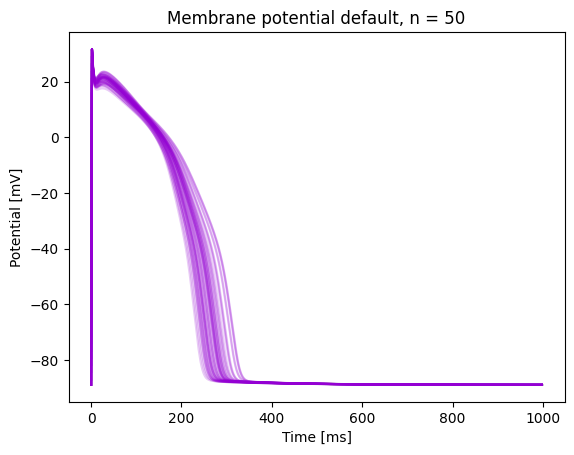

In [57]:
plot_V(times, [data[:, 0] for data in data_default_list], "default", save=True)

## Optimisation

### Setting up our error measure

The next main goal is to use objectives from the ToR-ORd genetic algorithm (see appendix 2 in [$^{[1]}$](#Sources)) within
an error measure to be optimised and from which we can perform inference. This will also dictate
our choice of likelihood function for that inference.

Below, we list the main aims of the genetic algorithm as they appear in the paper, and our interpretation going forward with the error measure. Note that although these were fused into a multicriterial function, we will simply sum their normalised contributions into a single scalar error measure.

|Objective description|Model setup|Error term|Contribution to error measure|
|------------|-----|----|------------|
|"similarity of action potential morphology to the reference."[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{APD}$|Normalised square error of APD90 values.|
|"calcium transient amplitude"[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{CaTA}$|Normalised square error of calcium transient amplitudes.|
|"calcium transient duration"[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{CaTD}$|Normalised square error of calcium transient duration from peak to 90% recovery.|
|"calcium transient amplitude reduction with sodium blockade"[$^{[1]}$](#Sources)|50% block of $I_{Na}$ and $I_{NaL}$|$\mathcal{E}_{BINa}$|$0$ if reduction is successful, $1$ otherwise.|
|"action potential duration reduction with calcium blockade"[$^{[1]}$](#Sources)|50% block of $I_{CaL}$|$\mathcal{E}_{BICaL}$|$0$ if reduction is successful, $1$ otherwise.|
|"depolarisation with $I_{K1}$ block"[$^{[1]}$](#Sources)|50% block of $I_{K_1}$|$\mathcal{E}_{BIK1}$|$0$ if the magnitude of the final potential is reduced, $1$ otherwise.|

Our first job is to set up all of the different model conditions listed in the table. Before we do this, we will pre-pace the
default model for $130$ beats, as done in[$^{[1]}$](#Sources).

Additionally, in the model code[$^{[5]}$](#Sources), APD90 is defined to be the time taken between peak potential and 90% reduction in amplitude. Our error measure will then be

\begin{equation}
    \mathcal{E} = \mathcal{E}_{APD} + \mathcal{E}_{CaTA} + \mathcal{E}_{CaTD} + \mathcal{E}_{BINa} + \mathcal{E}_{BICaL} + \mathcal{E}_{BIK1}.
\end{equation}

Now we can override the `pints.ProblemErrorMeasure` class to implement our custom error measure.

In [12]:
from scipy.interpolate import make_smoothing_spline

In [13]:
class ToRORdErrorMeasure(pints.ProblemErrorMeasure):

    def __init__(self, problem, problem_BINa, problem_BICaL, problem_BIK1, normalisation=None, metrics="biomarkers"):
        """We have a similar initialisation process to the ProblemErrorMeasure class, but we also
        include our extra models with various blockages of ion channels to take into account in
        the error measure.
        """
        super(ToRORdErrorMeasure, self).__init__(problem)
        self._problem_BINa = problem_BINa
        self._problem_BICaL = problem_BICaL
        self._problem_BIK1 = problem_BIK1
        self._n_errors = 5 if metrics == "traces" else 6
        if normalisation is None or len(normalisation) != self._n_errors:
            normalisation = np.array([1] * self._n_errors)
        self._normalisation = np.array(normalisation)
        self._metrics = metrics
        # Calculate these true values to be used for later and as normalisation
        # constants in the likelihood function
        self.true_APD90 = self.get_duration_90(self._values[:, 0], spline=True)
        self.true_CaTA = np.max(self._values[:, 1]) - self._values[0, 1]
        self.true_CaTD90 = self.get_duration_90(self._values[:, 1], spline=True)

    def __call__(self, x):
        errors = self.get_errors(x)
        # print([errors[i] / self._normalisation[i]**2 for i in range(len(errors))])
        return sum(errors)

    def get_errors(self, x):
        data_default = self._problem.evaluate(x)
        data_BINa = self._problem_BINa.evaluate(x)
        data_BICaL = self._problem_BICaL.evaluate(x)
        data_BIK1 = self._problem_BIK1.evaluate(x)
        if self._metrics == "traces":
            errors = [self.error_AP_trace(data_default),
                      self.error_Ca_trace(data_default)]
        else:
            errors = [self.error_APD90(data_default),
                      self.error_CaTA(data_default), 
                      self.error_CaTD90(data_default)]
        errors += [self.error_INa_block(data_default, data_BINa), 
                   self.error_ICaL_block(data_default, data_BICaL), 
                   self.error_IK1_block(data_default, data_BIK1)]
        return np.array(errors) / self._normalisation**2

    def error_APD90(self, data):
        """Computes the true APD90 and compares it to APD90 with the current parameter set.
        """
        new_APD90 = self.get_duration_90(data[:, 0], spline=True)
        return (self.true_APD90 - new_APD90) ** 2 / self.true_APD90 ** 2

    def error_AP_trace(self, data):
        """Computes the mean squared error across the entire action potential trace. This is an alternative
        to calculating the APD90 value.
        """
        V = data[:, 0]
        V_hat = self._values[:, 0]
        return np.sum((V - V_hat)**2) / len(self._times)

    def error_CaTA(self, data):
        """Computes the true Ca2+ transient amplitude and compares it to the amplitude with the current parameter
        set.
        """
        new_CaTA = np.max(data[:, 1]) - data[0, 1]
        return (self.true_CaTA - new_CaTA) ** 2 / self.true_CaTA ** 2

    def error_CaTD90(self, data):
        """Computes the true Ca2+ transient duration for 90% reduction and compares it to the duration with the
        current parameter set.
        """
        new_CaTD90 = self.get_duration_90(data[:, 1], spline=True)
        return (self.true_CaTD90 - new_CaTD90) ** 2 / self.true_CaTD90 ** 2

    def error_Ca_trace(self, data):
        """Computes the normalised sum of squared errors across the entire calcium transient. This is an alternative
        to calculating the CaTA and CaTD90 values.
        """
        Ca = data[:, 1]
        Ca_hat = self._values[:, 1]
        return np.sum((Ca - Ca_hat)**2) / len(self._times)

    def error_INa_block(self, data_default, data_BINa):
        """Compares the Ca2+ transient amplitude of the default model with that of a model with 50% block of I_Na and
        I_NaL. Returns 0 if there is a reduction in amplitude and 1 otherwise.
        """
        default_CaTA = np.max(data_default[:, 1])
        BINa_CaTA = np.max(data_BINa[:, 1])
        return 0.0 if default_CaTA > BINa_CaTA else 1.0

    def error_ICaL_block(self, data_default, data_BICaL):
        """Compares the APD90 of the default model with that of a model with 50% block of I_CaL. 
        Returns 0 if there is a reduction in duration and 1 otherwise.
        """
        default_APD90 = self.get_duration_90(data_default[:, 0])
        BICaL_APD90 = self.get_duration_90(data_BICaL[:, 0])
        return 0.0 if default_APD90 > BICaL_APD90 else 1.0

    def error_IK1_block(self, data_default, data_BIK1):
        """Compares the final (resting) potential of the default model with that of a model with
        50% block of I_K1. Returns 0 if there is a reduction in magnitude and 1 otherwise.
        """
        default_final_V = data_default[-1, 0]
        BIK1_final_V = data_BIK1[-1, 0]
        return 0.0 if default_final_V < BIK1_final_V else 1.0

    def get_duration_90(self, y, spline=False):
        """Retrieves the time between peak y and y at 90% of its resting value. y could represent the membrane potential
        or calcium transient. If spline=True then a smoothed cubic spline will be made of the data to calculate
        this duration.
        """
        if spline:
            spl = make_smoothing_spline(self._times, y, lam=2)
            y = spl(self._times)
        max_y = np.max(y)
        index_of_max_y = np.argmax(y)
        time_of_max_y = self._times[index_of_max_y]
        final_y = y[-1]
        threshold = final_y + 0.1 * (max_y - final_y)
        for i in range(index_of_max_y, len(y)):
            if y[i] < threshold:
                return self._times[i] - time_of_max_y

    def n_errors(self):
        """Returns the number of error terms in the model.
        """
        return self._n_errors

    def times(self):
        """Returns the array of times for the model.
        """
        return self._times

    def metrics(self):
        """Returns whether our metrics are biomarkers or traces.
        """
        return self._metrics
        

In [14]:
normalisation = None
scores = []
for i in range(50):
    scores.append(ToRORdErrorMeasure(problem_list[i], problem_BINa_list[i], problem_BICaL_list[i], 
                                     problem_BIK1_list[i], normalisation=normalisation))

### Saving biomarkers

Finally, we wish to store the different biomarkers/block conditions in a .csv file to take forward with us. We will do this through the
custom optimisation class defined above.

In [24]:
biomarker_df = pd.DataFrame(columns=["APD90", "CaTA", "CaTD90", "BINa", "BICaL", "BIK1"])
for i, score in enumerate(scores):
    biomarker_list = [score.true_APD90, score.true_CaTA, score.true_CaTD90,
                      score.error_INa_block(data_default_list[i], data_BINa_list[i]),
                      score.error_ICaL_block(data_default_list[i], data_BICaL_list[i]),
                      score.error_IK1_block(data_default_list[i], data_BIK1_list[i])]
    biomarker_df.loc[len(biomarker_df)] = biomarker_list
biomarker_df.to_csv("simulation_outputs/biomarkers.csv")

### Performing optimisation

Now, we optimise to get a good starting location for all the $156$ parameters.

In [15]:
boundaries = pints.RectangularBoundaries([1e-5, 1e-3, 1e-2],
                                         [1e-3, 1e-1, 1])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_23976\476093351.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [16]:
num_opts = 5

And here we perform the optimisation. We choose to run this `num_opts` times to try and find the optimal solution of the different
optimised parameters. Each optimisation is deemed complete if the objective function has not changed by more than $10^{-8}$ over a
period of $200$ iterations. We save the parameters from each optimisation to a .csv file.

We run this for each of the $50$ sets of parameters and then take a sample mean and standard deviation for the population-level parameters.

In [63]:
for i in range(50):
    for j in range(num_opts):
        xs = log_prior.sample(1)
        opt = pints.OptimisationController(scores[i], xs, boundaries=boundaries, method=pints.CMAES)
        opt.set_max_unchanged_iterations(120, 0.00000001)
        opt.set_max_iterations(500)
        opt_params, opt_values = opt.run()
        opt_param_df = pd.DataFrame({param_names[k]: [opt_params[k]] for k in range(model_defaults[0].n_parameters())})
        opt_param_df.to_csv(f"optimisation_outputs/set_{i}/opt_params_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      0.0285    0.0285     0:01.0
1     14     0.0137    0.0137     0:01.9
2     21     0.00524   0.00524    0:02.7
3     28     0.00524   0.00704    0:03.5
20    147    0.00305   0.00305    0:17.4
40    287    0.000397  0.00045    0:34.2
60    427    0.000392  0.000395   0:51.0
80    567    0.000392  0.000392   1:08.3
100   707    0.000392  0.000392   1:28.3
120   847    0.000392  0.000392   1:46.2
140   987    0.000392  0.000392   2:03.1
160   1127   0.000392  0.000392   2:19.9
180   1267   0.000392  0.000392   2:36.3
188   1316   0.000392  0.000392   2:42.0
Halting: No significant change for 120 iterations.
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      1.515706  

C:\Users\matth\AppData\Local\Temp\ipykernel_10128\2054155654.py:123: SyntaxWarning: invalid escape sequence '\_'
  print(beat, end='_/\_')


KeyboardInterrupt: 

In [31]:
opt_params = opt.optimiser().x_best()
opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model_defaults[0].n_parameters())})
opt_param_df.to_csv("optimisation_outputs/set_0/opt_params_0.csv")

### Collecting optimisation results

For each of the $50$ optimisations, we wish to take the parameter set which gives the overall minimal score. After this we will take the sample mean and sample standard deviations of all the parameters and use those as the starting positions for the top-level parameters.

In [17]:
num_opts = 5

In [18]:
opt_params = []
opt_errors = []
true_scores = []
for i in range(50):
    errors_i = []
    param_sets = []
    for j in range(num_opts):
        opt_param_df = pd.read_csv(f"optimisation_outputs/set_{i}/opt_params_{j}.csv", index_col=0)
        param_set_j = opt_param_df.to_numpy()[0]
        param_sets.append(param_set_j)
        errors_i.append(scores[i](param_set_j))
        true_scores.append(scores[i](conductances[i, :]))
    opt_index = np.argmin(errors_i)
    opt_errors.append(errors_i[opt_index])
    min_set = param_sets[opt_index]
    opt_params.append(min_set)

In [19]:
errors = []
for i in range(50):
    print("---------------------------------------------------------------------------")
    print(f"True parameter set {i}, sum of squared errors = {round(true_scores[i], 5)}")
    print("---------------------------------------------------------------------------")
    print(f"Optimisation of set {i}, sum of squared errors = {round(opt_errors[i], 5)}")
    print("---------------------------------------------------------------------------")
    output_list = []
    for k in range(model_defaults[0].n_parameters()):
        opt_param = round(opt_params[i][k], 10)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[k]}, True: {conductances[i, k]}, Optimised: {opt_param}")
    output_param_dfs[i][f"Optimisation of set {i}"] = output_list

---------------------------------------------------------------------------
True parameter set 0, sum of squared errors = 0.00106
---------------------------------------------------------------------------
Optimisation of set 0, sum of squared errors = 0.00012
---------------------------------------------------------------------------
Parameter: P_Cab, True: 8.999749309706428e-05, Optimised: 9.46746e-05
Parameter: G_Kr, True: 0.0314342573898607, Optimised: 0.033387329
Parameter: G_ClCa, True: 0.311920677707304, Optimised: 0.057950065
---------------------------------------------------------------------------
True parameter set 1, sum of squared errors = 0.00106
---------------------------------------------------------------------------
Optimisation of set 1, sum of squared errors = 0.0
---------------------------------------------------------------------------
Parameter: P_Cab, True: 0.0001028916617524, Optimised: 0.0001006894
Parameter: G_Kr, True: 0.0309725515007071, Optimised: 0.028

In [46]:
means = np.mean(opt_params, axis=0)
std_devs = np.std(opt_params, axis=0)
x0 = np.array(np.hstack(opt_params).tolist() + 
              [means[0], std_devs[0], means[1], std_devs[1], means[2], std_devs[2]])
x0 = np.tile(x0, (1, 1))

In [47]:
x0_df = pd.DataFrame(x0.transpose(), columns=["x0"])
x0_df.to_csv("optimisation_outputs/x0_biomarkers.csv")

### Setting up our likelihood

As with the error measure, we wish to create custom likelihood functions for the inference process. This will mimic the behaviour
of the error measure. Also, each of these are inner likelihood functions, which will be appended to the overall likelihood with the population
of models. As many of the operations are the same as the error measure, we use composition to pass a `ToRORdErrorMeasure` to
the constructor for the log likelihood, which will take the form

\begin{equation}
    L(\mathbf{G}, \mathbf{\sigma} | \mathbf{x}) = -3\log{2\pi} -\sum_{i \in I}\left[\log{\sigma_{i}} + \frac{\mathcal{E}_{i}(\mathbf{G} | \mathbf{x})}{2\pi\sigma_{i}^{2}}\right],
\end{equation}
where $\mathbf{G}$ is the vector of conductances to be inferred, $\mathbf{\sigma}$ is the vector of standard deviations for each normally distributed error term, $\mathbf{x}$ is the data vector and $I = \{APD, CaTA, CaTD, BINa, BICaL, BIK1\}$.

If we are instead using the entire action potential and calcium traces, the form of the log likelihood looks slightly different, as we are recording
data across all time steps $t$ for these measures. In this scenario,

\begin{equation}
    L(\mathbf{G}, \mathbf{\sigma} | \mathbf{x}) = -\frac{3}{2}\log{2\pi} -\sum_{i \in I_{1}}\left[\log{\sigma_{i}} + \frac{\mathcal{E}_{i}(\mathbf{G} | \mathbf{x})}{2\pi\sigma_{i}^{2}}\right] - T\left(\log{2\pi} + \sum_{i \in I_{2}}\left[\log{\sigma_{i}} + \frac{\mathcal{E}_{i}(\mathbf{G} | \mathbf{x})}{2\pi\sigma_{i}^{2}}\right]\right),
\end{equation}
where $I_{1} = \{BINa, BICaL, BIK1\}$, $I_{2} = \{APTr, CaTr\}$ and $T$ is the number of time points we evaluate on.

In [20]:
class ToRORdLogLikelihood(chi.LogLikelihood):

    def __init__(self, problem: pints.MultiOutputProblem, torord_error_measure: ToRORdErrorMeasure,
                 error_model,
                 metrics="biomarkers", sigma=None):
        """We have a similar initialisation process to the ProblemLogLikelihood class, but we also
        include our error measure instance. We will store the number of terms (the number of error
        terms in our measure) in the function too.
        """
        super(ToRORdLogLikelihood, self).__init__(problem._model, error_model, [torord_error_measure._values[:, 0], torord_error_measure._values[:, 1]], 
                                                  [problem._times, problem._times])
        self._torord_error_measure = torord_error_measure
        self._n_terms = torord_error_measure.n_errors()
        self._n_times = len(torord_error_measure.times())
        self._sigma = sigma
        self._problem = problem

        # Here we add the number of parameters of the problem to the number of error terms to get all parameters
        # If we specify the sigma values, then we reduce the number of parameters we need to infer
        self._n_parameters = problem.n_parameters() + self._n_terms if sigma is None else problem.n_parameters()
        self._metrics = metrics

    def __call__(self, x):
        """Here we calculate the log likelihood using the different error terms.
        """
        if self._sigma is None:
            end_index = -self._n_terms
            sigma = np.asarray(x[end_index:])
        else:
            end_index = self._n_parameters
            sigma = self._sigma
        if any(sigma <= 0):
            return -np.inf
        errors = self._torord_error_measure.get_errors(x[:end_index])
        # print(errors)
        log_likelihood = -self._n_terms / 2 * np.log(2 * np.pi) - np.sum(np.log(sigma) + errors / (2 * np.pi * sigma**2))
        # print(log_likelihood)
        if self._metrics == "traces":
            log_likelihood += -(self._n_times - 1) * np.sum(np.log(2 * np.pi) / 2 + np.log(sigma[0:2]) + errors[0:2] / (2 * np.pi * sigma[0:2]**2))
        # print(log_likelihood)
        return log_likelihood

### Normalising

For our likelihood, we have control over the standard deviations, where these values are determined by the
literature for biomarkers, and determined by our chosen noise implementation for the traces. The binary conditions are chosen to have a standard deviation of $0.1$.

|Error term|Standard Deviation|Source|
|------------|-----|------------|
|$\mathcal{E}_{APD}$|66ms|Britton *et al.* pg 3[$^{[1]}$](#Sources)|
|$\mathcal{E}_{CaTA}$|20nM|Coppini *et al.* Fig. 3B Top[$^{[2]}$](#Sources)|
|$\mathcal{E}_{CaTD}$|40ms|Coppini *et al.* Fig. 3B Bottom[$^{[2]}$](#Sources)|

We also have to normalise out by the magnitudes of the true values used in the error function. This cancels out the contribution
from the original error term so that the standard deviations truly match what they are in the literature for the likelihood function.

In [21]:
error_models = [chi.GaussianErrorModel(), chi.GaussianErrorModel()]

In [22]:
log_likelihoods = []
for i in range(50):
    sigma = np.array([66 / scores[i].true_APD90, 20e-6 / scores[i].true_CaTA, 40 / scores[i].true_CaTD90, 0.1, 0.1, 0.1])
    log_likelihoods.append(ToRORdLogLikelihood(problem_list[i], scores[i], error_models, sigma=sigma))

## Creating a `PopulationModel` using chi[$^{[6]}$](#Sources)

Now, we will create our `PopulationModel` to perform hierarchical inference on. This will be done using the package chi[$^{[6]}$](#Sources), which is designed for hierarchical inference and populations of models.

In [79]:
!pip install chi-drm


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/118.8 kB ? eta -:--:--
   ---------------------------------------- 118.8/118.8 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.7 MB 14.3 MB/s eta 0:00:01
   -------------- ------------------------- 0.6/1.7 MB 9.6 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.7 MB 7.7 MB/s eta 0:00:01
   ----------------------------- ---------- 1.2/1.7 MB 8.7 MB/s eta 0:00:01
   ---------------------------------- ----- 1.4/1.7 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ----- ---------------------------------- 0.6/4.0 MB 11.5 MB/s eta 0:00:01
   ---------- ----------------------------- 1.0/4.0 MB 11.0 MB/s eta 0:00:01
   ---------- ----------------------------- 1.0/4.0 MB 11.0 MB/s eta 0:00:01
   --------------- ---

In [23]:
import chi

We will need to set up the population model with our hyperparameters. These will be the means and standard deviations governing the
distributions of the conductances. To do this we will use Gaussian distributions for all three parameters.

In [24]:
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=["P_Cab"]),
    chi.GaussianModel(dim_names=["G_Kr"]),
    chi.GaussianModel(dim_names=["G_ClCa"])
])
log_likelihood = chi.HierarchicalLogLikelihood(
    log_likelihoods=log_likelihoods,
    population_model=population_model
)

### Calculating prior and initialising chains

Our prior encompasses the guesses for the six different hyperparameters of the problem: the means and standard deviations governing
the distributions of the conductances on a population level.

In [25]:
log_prior = pints.ComposedLogPrior(
    pints.UniformLogPrior(1e-5, 1e-3),      # Mean for P_Cab
    pints.UniformLogPrior(1e-6, 3e-4),      # Std. dev. for P_Cab
    pints.UniformLogPrior(1e-3, 1e-1),      # Mean for G_Kr
    pints.UniformLogPrior(1e-4, 3e-2),   # Std. dev. for G_Kr
    pints.UniformLogPrior(1e-2, 1),     # Mean for G_ClCa
    pints.UniformLogPrior(1e-3, 3e-1)      # Std. dev. for G_ClCa
)
log_posterior = chi.HierarchicalLogPosterior(
    log_likelihood=log_likelihood, log_prior=log_prior)

C:\Users\matth\AppData\Local\Temp\ipykernel_23976\1430152516.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-5, 1e-3),      # Mean for P_Cab
C:\Users\matth\AppData\Local\Temp\ipykernel_23976\1430152516.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-6, 3e-4),      # Std. dev. for P_Cab
C:\Users\matth\AppData\Local\Temp\ipykernel_23976\1430152516.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-3, 1e-1),      # Mean for G_Kr
C:\Users\matth\AppData\Local\Temp\ipykernel_23976\1430152516.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-4, 3e-2),   # Std. dev. 

Here, we carry out the inference below.

In [26]:
class SamplingController(chi.SamplingController):

    def __init__(self, log_posterior, seed=None):
        super(SamplingController, self).__init__(log_posterior, seed)

    def run(self, x0, n_iterations=10000, hyperparameters=None,
            log_to_screen=False):
        # Set up sampler
        sampler = pints.MCMCController(
            log_pdf=self._log_posterior,
            chains=self._n_runs,
            x0=x0,
            method=self._sampler,
            transformation=self._transform)

        # Configure sampling routine
        sampler.set_log_to_screen(log_to_screen)
        sampler.set_log_interval(iters=20, warm_up=3)
        sampler.set_max_iterations(iterations=n_iterations)
        sampler.set_parallel(self._parallel_evaluation)

        if hyperparameters:
            for s in sampler.samplers():
                s.set_hyper_parameters(hyperparameters)

        # Run sampling routine
        chains = sampler.run()

        return chains

In [30]:
# Infer posterior
transform = pints.RectangularBoundariesTransformation([1e-6, 1e-3, 1e-2] * 50 + [1e-5, 1e-6, 1e-3, 1e-4, 1e-2, 1e-3],
                                                      [1e-3, 1e-1, 1] * 50 + [1e-3, 3e-4, 1e-1, 3e-2, 1, 3e-1])
controller = SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_transform(transform)
controller.set_sampler(pints.HaarioBardenetACMC)
n_iterations = 20000
posterior_samples = controller.run(x0, n_iterations, log_to_screen=True)

Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:08.4
1     2      0          0:16.5
2     3      0          0:24.2
3     4      0          0:31.5
20    21     0          2:45.9


C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


40    41     0          4:51.3
60    61     0          6:55.5
80    81     0          9:00.3
100   101    0         10:58.6
120   121    0         12:58.0
140   141    0         14:55.5
160   161    0         16:55.1
180   181    0         18:53.6
Initial phase completed.
200   201    0         20:52.0
220   221    0.0452    22:49.7
240   241    0.0788    24:47.4
260   261    0.107     26:45.5
280   281    0.117     28:55.5
300   301    0.123     30:55.2
320   321    0.14      32:54.5
340   341    0.143695  34:53.3
360   361    0.144     36:51.9
380   381    0.152231  38:50.7
400   401    0.155     40:48.8
420   421    0.159     42:57.0
440   441    0.156     44:54.3
460   461    0.163     46:52.4
480   481    0.166     48:50.4
500   501    0.164     50:48.0
520   521    0.163     52:56.0
540   541    0.166     54:59.2
560   561    0.168     57:03.1
580   581    0.17      59:08.9
600   601    0.175     61:12.6
620   621    0.172     63:21.7
640   641    0.174727  65:25.5
660   661    0

In [32]:
all_param_names = []
for i in range(50):
    inner_list = [f"P_Cab_{i}", f"G_Kr_{i}", f"G_ClCa_{i}"]
    all_param_names += inner_list
all_param_names += ["mu_P_Cab", "sigma_P_Cab", "mu_G_Kr", "sigma_G_Kr", "mu_G_ClCa", "sigma_G_ClCa"]

df = pd.DataFrame(posterior_samples[0], columns=all_param_names)
df.to_csv("chains/lca_kr_cl/chain.csv")

In [27]:
print(log_posterior.n_parameters())

156


## Plots

### Recovering chains from .csv files

In [28]:
num_chains = 1
list_of_chains = []
for i in range(num_chains):
    df = pd.read_csv("chains/lca_kr_cl/chain.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

Finally, write all parameter information to an output file.

In [33]:
for i, df in enumerate(output_param_dfs):
    df.insert(0, "Name", models[0].get_unfixed_param_names())
    df.to_csv(f"param_info/param_info_{i}.csv")

## Whole action potential trace

Now we move on to optimising over the whole action potential trace.

|New error term|Model setup|Error term|Contribution to error measure|
|------------|-----|----|------------|
|Full action potential trace[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{APTr}$|Normalised mean square error of whole AP trace.|
|Full calcium transient[$^{[1]}$](#Sources)|Default|$\mathcal{E}_{CaTr}$|Normalised mean square error of whole calcium transient.|

$\mathcal{E} = \mathcal{E}_{APTr} + \mathcal{E}_{CaTr} + \mathcal{E}_{BINa} + \mathcal{E}_{BICaL} + \mathcal{E}_{BIK1}$

We also normalise by the noise contributions from before for the action potential and calcium transient traces

In [34]:
output_param_Tr_dfs = []
for i in range(50):
    output_param_Tr_dfs.append(pd.DataFrame({"true": conductance_df.iloc[i].to_numpy()}))

In [35]:
normalisation = [1, 3e-6, 1, 1, 1]
scores_Tr = []
for i in range(50):
    scores_Tr.append(ToRORdErrorMeasure(problem_list[i], problem_BINa_list[i], problem_BICaL_list[i], 
                                        problem_BIK1_list[i], normalisation=normalisation, metrics="traces"))

### Performing optimisation

And here we perform the optimisation. We choose to run this `num_opts` times to try and find the optimal solution of the different
optimised parameters. Each optimisation is deemed complete if the objective function has not changed by more than $10^{-8}$ over a
period of $200$ iterations. We save the parameters from each optimisation to a .csv file.

We run this for $50$ optimisations and then take a sample mean and sample standard deviation for the population-level parameters.

In [36]:
boundaries = pints.RectangularBoundaries([1e-5, 1e-3, 1e-2],
                                         [1e-3, 1e-1, 1])
log_prior = pints.UniformLogPrior(boundaries)

C:\Users\matth\AppData\Local\Temp\ipykernel_23976\476093351.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(boundaries)


In [39]:
num_opts = 5
for i in range(1, 50):
    for j in range(num_opts):
        xs = log_prior.sample(1)
        opt = pints.OptimisationController(scores_Tr[i], xs, boundaries=boundaries, method=pints.CMAES)
        opt.set_max_unchanged_iterations(120, 0.000001)
        opt.set_max_iterations(500)
        opt_params, opt_values = opt.run()
        opt_param_df = pd.DataFrame({param_names[k]: [opt_params[k]] for k in range(model_defaults[0].n_parameters())})
        opt_param_df.to_csv(f"optimisation_outputs/set_{i}/opt_params_Tr_{j}.csv")

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      5836.856  5836.856   0:02.5
1     14     4970.225  4970.225   0:05.0
2     21     3111.967  3111.967   0:07.5
3     28     563.219   563.219    0:09.8
20    147    34.64338  34.64338   0:44.5
40    287    2.261433  3.590968   1:25.8
60    427    2.25667   2.258474   2:08.7
80    567    2.178983  2.196732   2:50.1
100   707    1.938454  1.941067   3:30.9
120   847    1.936904  1.936907   4:12.0
140   987    1.936903  1.936903   4:53.1
160   1127   1.936903  1.936903   5:35.0
180   1267   1.936903  1.936904   6:16.2
200   1407   1.936903  1.936903   6:57.4
220   1547   1.936903  1.936903   7:38.6
240   1687   1.936903  1.936903   8:21.2
260   1827   1.936903  1.936903   9:07.0
267   1869   1.936903  1.936903   9:19.6
Halting: No significant change for 120 iterations.
Minimising error measure
Using Cova

C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


100   707    1.945201  1.946626   1:19.3
120   847    1.944483  1.944483   1:34.5
140   987    1.944481  1.944481   1:49.7
160   1127   1.944481  1.944481   2:04.9
180   1267   1.944481  1.944481   2:20.0
200   1407   1.944481  1.944481   2:35.3
220   1547   1.944481  1.944481   2:50.6
240   1687   1.944481  1.944481   3:05.7
243   1701   1.944481  1.944481   3:07.2
Halting: No significant change for 120 iterations.
Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7      115.9011  115.9011   0:00.8
1     14     115.5502  115.5502   0:01.6
2     21     109.6733  109.6733   0:02.4
3     28     109.6733  112.7466   0:03.1
20    147    98.65576  98.65576   0:16.2
40    287    6.008262  6.747125   0:32.8
60    427    5.926011  5.926011   0:48.6
80    567    5.773595  5.773595   1:04.4
100   707    2.116884  2.116884   1:20.1
120   847    1.944564  1.944564   1

In [35]:
opt_params = opt.optimiser().x_best()
opt_param_df = pd.DataFrame({param_names[i]: [opt_params[i]] for i in range(model_defaults[0].n_parameters())})
opt_param_df.to_csv("optimisation_outputs/set_1/opt_params_Tr_0.csv")

### Collecting optimisation results

Here, we will read all the .csv files and choose the parameter sets which give the minimal score. We then take the sample mean and sample standard deviation of these sets for the top-level parameters.

In [37]:
num_opts = 5
opt_params = []
opt_errors = []
true_scores = []
for i in range(50):
    errors_i = []
    param_sets = []
    for j in range(num_opts):
        opt_param_df = pd.read_csv(f"optimisation_outputs/set_{i}/opt_params_Tr_{j}.csv", index_col=0)
        param_set_j = opt_param_df.to_numpy()[0]
        param_sets.append(param_set_j)
        errors_i.append(scores_Tr[i](param_set_j))
        true_scores.append(scores_Tr[i](conductances[i, :]))
    opt_index = np.argmin(errors_i)
    opt_errors.append(errors_i[opt_index])
    min_set = param_sets[opt_index]
    opt_params.append(min_set)

In [38]:
errors = []
for i in range(50):
    print("---------------------------------------------------------------------------")
    print(f"True parameter set {i}, sum of squared errors = {round(true_scores[i], 5)}")
    print("---------------------------------------------------------------------------")
    print(f"Optimisation of set {i}, sum of squared errors = {round(opt_errors[i], 5)}")
    print("---------------------------------------------------------------------------")
    output_list = []
    for k in range(model_defaults[0].n_parameters()):
        opt_param = round(opt_params[i][k], 10)
        output_list.append(opt_param)
        print(f"Parameter: {param_names[k]}, True: {conductances[i, k]}, Optimised: {opt_param}")
    output_param_Tr_dfs[i][f"Optimisation of set {i}"] = output_list

---------------------------------------------------------------------------
True parameter set 0, sum of squared errors = 1.94444
---------------------------------------------------------------------------
Optimisation of set 0, sum of squared errors = 1.94273
---------------------------------------------------------------------------
Parameter: P_Cab, True: 8.999749309706428e-05, Optimised: 9.01011e-05
Parameter: G_Kr, True: 0.0314342573898607, Optimised: 0.0314388756
Parameter: G_ClCa, True: 0.311920677707304, Optimised: 0.309450703
---------------------------------------------------------------------------
True parameter set 1, sum of squared errors = 1.94444
---------------------------------------------------------------------------
Optimisation of set 1, sum of squared errors = 1.9369
---------------------------------------------------------------------------
Parameter: P_Cab, True: 0.0001028916617524, Optimised: 0.0001025605
Parameter: G_Kr, True: 0.0309725515007071, Optimised: 0

In [30]:
means = np.mean(opt_params, axis=0)
std_devs = np.std(opt_params, axis=0)
x0 = np.array(np.hstack(opt_params).tolist() + 
              [means[0], std_devs[0], means[1], std_devs[1], means[2], std_devs[2]])
x0 = np.tile(x0, (1, 1))

In [ ]:
x0_df = pd.DataFrame(x0.transpose(), columns=["x0"])
x0_df.to_csv("optimisation_outputs/x0_biomarkers_Tr.csv")

### Creating error models and log-likelihood

In [39]:
error_models = [chi.GaussianErrorModel(), chi.GaussianErrorModel()]

In [40]:
log_likelihoods_Tr = []
for i in range(50):
    sigma = np.array([1, 1, 0.1, 0.1, 0.1])
    log_likelihoods_Tr.append(ToRORdLogLikelihood(problem_list[i], scores_Tr[i], error_models, sigma=sigma, metrics="traces"))

### Creating a `PopulationModel` using chi[$^{[6]}$](#Sources)

In [34]:
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=["P_Cab"]),
    chi.GaussianModel(dim_names=["G_Kr"]),
    chi.GaussianModel(dim_names=["G_ClCa"])
])
log_likelihood_Tr = chi.HierarchicalLogLikelihood(
    log_likelihoods=log_likelihoods_Tr,
    population_model=population_model
)

### Calculating prior and initialising chains

In [37]:
log_prior_pop = pints.ComposedLogPrior(
    pints.UniformLogPrior(1e-5, 1e-3),      # Mean for P_Cab
    pints.UniformLogPrior(1e-6, 1e-4),      # Std. dev. for P_Cab
    pints.UniformLogPrior(1e-3, 1e-1),      # Mean for G_Kr
    pints.UniformLogPrior(1e-4, 1e-2),   # Std. dev. for G_Kr
    pints.UniformLogPrior(1e-2, 1),     # Mean for G_ClCa
    pints.UniformLogPrior(1e-3, 1e-1)      # Std. dev. for G_ClCa
)
log_posterior_Tr = chi.HierarchicalLogPosterior(
    log_likelihood=log_likelihood_Tr, log_prior=log_prior_pop)

C:\Users\matth\AppData\Local\Temp\ipykernel_10128\1952678587.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-5, 1e-3),      # Mean for P_Cab
C:\Users\matth\AppData\Local\Temp\ipykernel_10128\1952678587.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-6, 1e-4),      # Std. dev. for P_Cab
C:\Users\matth\AppData\Local\Temp\ipykernel_10128\1952678587.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-3, 1e-1),      # Mean for G_Kr
C:\Users\matth\AppData\Local\Temp\ipykernel_10128\1952678587.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior(1e-4, 1e-2),   # Std. dev. 

### Running the hierachical inference

In [39]:
# Infer posterior
transform = pints.RectangularBoundariesTransformation([1e-6, 1e-3, 1e-2] * 50 + [1e-5, 1e-6, 1e-3, 1e-4, 1e-2, 1e-3],
                                                      [1e-3, 1e-1, 1] * 50 + [1e-3, 1e-4, 1e-1, 1e-2, 1, 1e-1])
controller = SamplingController(log_posterior_Tr)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_transform(transform)
controller.set_sampler(pints.HaarioBardenetACMC)
n_iterations = 20000
posterior_samples = controller.run(x0, n_iterations, log_to_screen=True)

Using Haario-Bardenet adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:05.5
1     2      0          0:10.6
2     3      0          0:15.6
3     4      0          0:20.7
20    21     0          1:47.4
40    41     0          3:28.5
60    61     0          5:33.6
80    81     0          8:20.1
100   101    0         10:11.4
120   121    0         11:56.0
140   141    0         13:40.8
160   161    0         15:30.8
180   181    0         17:32.8
Initial phase completed.
200   201    0         19:29.8
220   221    0         21:28.0
240   241    0.0166    23:20.3
260   261    0.0651    25:14.0
280   281    0.107     27:07.4
300   301    0.13      28:59.9
320   321    0.152648  30:51.4
340   341    0.167     32:49.9


C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


360   361    0.166205  34:45.6
380   381    0.178     36:39.3
400   401    0.19202   38:32.0
420   421    0.2       40:25.6
440   441    0.2       42:16.5
460   461    0.195     44:10.6
480   481    0.204     46:08.2
500   501    0.212     48:03.9
520   521    0.217     49:57.5
540   541    0.214     51:50.6
560   561    0.214     53:45.2
580   581    0.21      55:38.1
600   601    0.216     57:31.5
620   621    0.221     59:23.1
640   641    0.214     61:15.9
660   661    0.213     63:06.2
680   681    0.22      64:58.6
700   701    0.22      66:49.8
720   721    0.219     68:42.3
740   741    0.221     70:33.4
760   761    0.221     72:27.4
780   781    0.22      74:18.6
800   801    0.217     76:10.7
820   821    0.218     78:07.0
840   841    0.21522   79:58.0
860   861    0.216     81:49.3
880   881    0.215     83:40.8
900   901    0.212     85:30.4
920   921    0.211     87:21.0
940   941    0.208     89:11.6
960   961    0.207076  91:03.3
980   981    0.207     92:53.6
1000  10

We save the chains below.

In [40]:
all_param_names = []
for i in range(50):
    inner_list = [f"P_Cab_{i}", f"G_Kr_{i}", f"G_ClCa_{i}"]
    all_param_names += inner_list
all_param_names += ["mu_P_Cab", "sigma_P_Cab", "mu_G_Kr", "sigma_G_Kr", "mu_G_ClCa", "sigma_G_ClCa"]

df = pd.DataFrame(posterior_samples[0], columns=all_param_names)
df.to_csv("chains/lca_kr_cl_Tr/chain.csv")

## Plots

### Recovering from .csv files

In [222]:
num_chains = 1
list_of_chains = []
for i in range(num_chains):
    df = pd.read_csv(f"chain_data/na_lca_kr_cl_to_Tr/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

In [41]:
for i, df in enumerate(output_param_Tr_dfs):
    df.insert(0, "Name", models[0].get_unfixed_param_names())
    df.to_csv(f"param_info/param_info_Tr_{i}.csv")

## Sources

$^{[1]}$ J. Tomek *et al.*, Development, calibration, and validation of a novel human ventricular myocyte model in health, disease, and drug block, eLife **8** (2019), e48890, https://doi.org/10.7554/eLife.48890.

$^{[2]}$ E. Grandi *et al.*, A Novel Computational Model of the Human Ventricular Action Potential and Ca Transient, J. Mol. Cell Cardiol. **48** (2010), pp. 112, https://pubmed.ncbi.nlm.nih.gov/19835882/.

$^{[3]}$ T. O’Hara *et al.*, Simulation of the Undiseased Human Cardiac Ventricular Action Potential: Model Formulation and Experimental 
Validation, PLoS Comput. Biol. **7** (2011), e100206, https://doi.org/10.1371/journal.pcbi.10020611.

$^{[4]}$ Y. Lu *et al.*, Effects of premature stimulation on HERG K+ channels, J. Physiol. **537** (2001), pp. 843-851, https://pubmed.ncbi.nlm.nih.gov/11744759/.

$^{[5]}$ J. Tomek, Repository for the cardiac model ToR-ORd, Github, 4ffab13, https://github.com/jtmff/torord. Date first accessed: 2024-04-22.

$^{[6]}$ D. Augustin, Chi: A Python package for treatment response modelling., J. Open Source Softw. **9**(94) (2024), pp. 5925, https://doi.org/10.21105/joss.05925